In [ ]:
!pip install python-binance ccxt ta plotly pandas numpy seaborn dash --quiet

**Key Features to Note**

Automatic Data Cleaning

*   Handles NaN values
*   Ensures data consistency

Flexible Analysis


*   Customizable z-score threshold
*   Multiple technical indicators

Comprehensive Visualization


*   Multi-panel plots
*   Clear anomaly highlighting



Pattern Detection


*  Overbought/oversold conditions
*  Price breakouts
*  Volume anomalies


In [ ]:
# Import all required libraries
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.volume import VolumeWeightedAveragePrice
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from dash import Dash, html, dcc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from functools import lru_cache
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# Data Collection
class CryptoDataCollector:
    def __init__(self, exchange_id='kraken'):
        self.exchange = getattr(ccxt, exchange_id)({
            'enableRateLimit': True,
            'options': {'defaultType': 'spot'}
        })

    def fetch_data(self, symbol='BTC/USD', timeframe='1h', limit=500):
        try:
            ohlcv = self.exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            return df
        except Exception as e:
            print(f"Error with {self.exchange.id}: {e}")
            return None

The below is a crypto analysis tool that combines traditional technical indicators (RSI, MACD, Bollinger Bands) with advanced anomaly detection to spot market patterns and potential manipulation. It fetches real-time data from Kraken, processes it through multiple analytical layers, and presents insights through an interactive dashboard, helping traders make more informed decisions.

Data collected successfully!

Data shape: (500, 5)

First few rows:
                         open      high       low     close      volume
timestamp                                                              
2025-01-20 08:00:00  106948.8  108150.0  106927.4  108141.2  122.776422
2025-01-20 09:00:00  108141.3  109000.0  107479.8  107998.0  184.381113
2025-01-20 10:00:00  107998.1  108547.6  107647.5  107797.0  122.196630
2025-01-20 11:00:00  107797.1  108295.3  107676.0  108100.0   78.748505
2025-01-20 12:00:00  108100.0  108500.0  105280.8  106750.1  320.800564


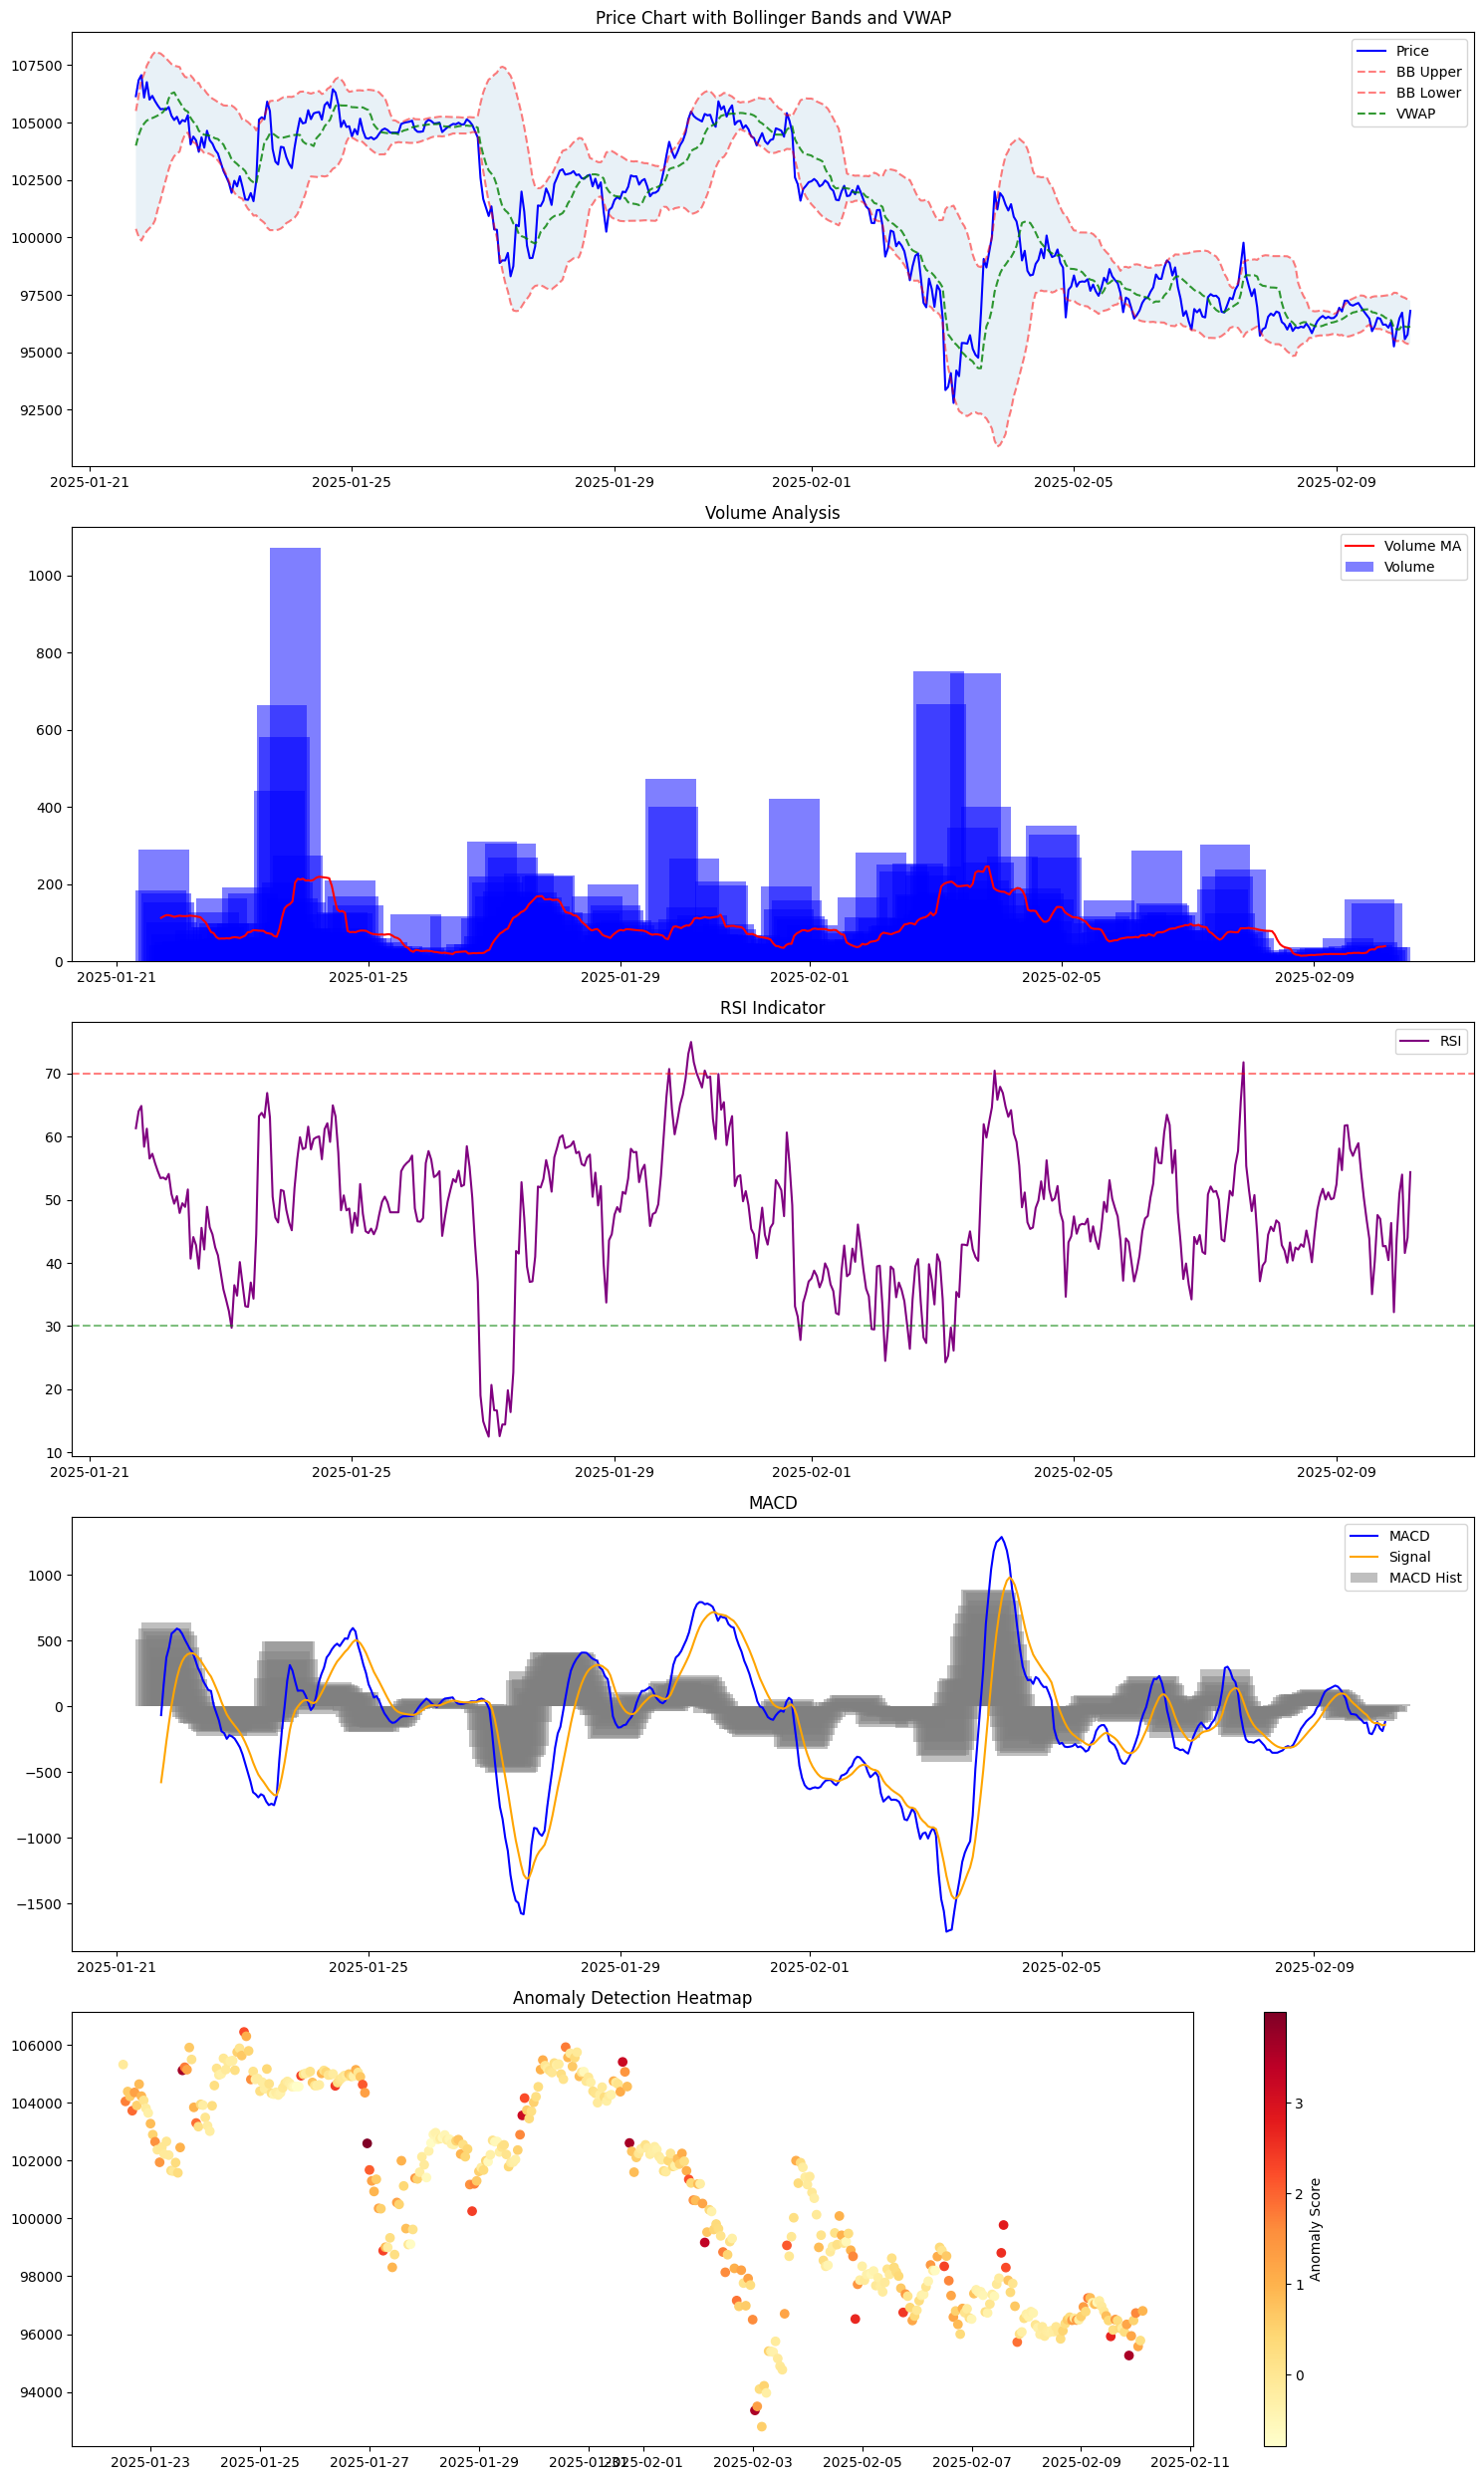


Summary of potential manipulation:
Number of volume anomalies: 15
Number of price anomalies: 7
Number of overbought periods: 8
Number of oversold periods: 26

Highest anomaly scores:
                        close      volume  anomaly_score
timestamp                                               
2025-01-26 23:00:00  102596.5  310.101501       3.995661
2025-01-23 14:00:00  105124.0  442.297759       3.645015
2025-01-31 18:00:00  102610.2  421.839153       3.617304
2025-02-09 21:00:00   95260.0  160.371927       3.572067
2025-02-03 01:00:00   93360.4  752.525095       3.562006


In [ ]:
class UnifiedCryptoAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.prepare_data()

    def prepare_data(self):
        # Calculate returns and log returns
        self.df['returns'] = self.df['close'].pct_change()
        self.df['log_returns'] = np.log(self.df['close']).diff()

        # Add technical indicators
        # RSI
        rsi_indicator = RSIIndicator(self.df['close'])
        self.df['rsi'] = rsi_indicator.rsi()

        # MACD
        macd = MACD(self.df['close'])
        self.df['macd'] = macd.macd()
        self.df['macd_signal'] = macd.macd_signal()
        self.df['macd_hist'] = macd.macd_diff()

        # Bollinger Bands
        bb = BollingerBands(self.df['close'])
        self.df['bb_high'] = bb.bollinger_hband()
        self.df['bb_low'] = bb.bollinger_lband()
        self.df['bb_mid'] = bb.bollinger_mavg()

        # Volume analysis
        self.df['volume_ma'] = self.df['volume'].rolling(window=20).mean()
        self.df['volume_std'] = self.df['volume'].rolling(window=20).std()
        self.df['volume_zscore'] = (self.df['volume'] - self.df['volume_ma']) / self.df['volume_std']

        # VWAP
        vwap = VolumeWeightedAveragePrice(
            high=self.df['high'],
            low=self.df['low'],
            close=self.df['close'],
            volume=self.df['volume'],
            window=14
        )
        self.df['vwap'] = vwap.volume_weighted_average_price()

        # Clean up NaN values
        self.df = self.df.dropna()

    def detect_anomalies(self, zscore_threshold=3):
        """Detect potential market manipulation patterns"""
        # Price manipulation detection
        rolling_std = self.df['returns'].rolling(window=20).std()
        self.df['price_zscore'] = np.abs(self.df['returns']) / rolling_std

        # Volume manipulation detection
        self.df['suspicious_volume'] = self.df['volume_zscore'] > zscore_threshold
        self.df['suspicious_price'] = self.df['price_zscore'] > zscore_threshold

        # Combined anomaly score
        self.df['anomaly_score'] = (self.df['price_zscore'] + self.df['volume_zscore']) / 2

        # Additional pattern detection
        self.df['overbought'] = self.df['rsi'] > 70
        self.df['oversold'] = self.df['rsi'] < 30
        self.df['price_above_bb'] = self.df['close'] > self.df['bb_high']
        self.df['price_below_bb'] = self.df['close'] < self.df['bb_low']

        return self.df

    def plot_analysis(self):
        """Create comprehensive visualization of the analysis"""
        fig, axes = plt.subplots(5, 1, figsize=(15, 25))

        # 1. Price Chart with Bollinger Bands and VWAP
        axes[0].plot(self.df.index, self.df['close'], label='Price', color='blue')
        axes[0].plot(self.df.index, self.df['bb_high'], 'r--', alpha=0.5, label='BB Upper')
        axes[0].plot(self.df.index, self.df['bb_low'], 'r--', alpha=0.5, label='BB Lower')
        axes[0].plot(self.df.index, self.df['vwap'], 'g--', alpha=0.8, label='VWAP')
        axes[0].fill_between(self.df.index, self.df['bb_high'], self.df['bb_low'], alpha=0.1)
        axes[0].set_title('Price Chart with Bollinger Bands and VWAP')
        axes[0].legend()

        # 2. Volume Analysis
        axes[1].bar(self.df.index, self.df['volume'], alpha=0.5, label='Volume', color='blue')
        axes[1].plot(self.df.index, self.df['volume_ma'], 'r', label='Volume MA')
        axes[1].set_title('Volume Analysis')
        axes[1].legend()

        # 3. RSI
        axes[2].plot(self.df.index, self.df['rsi'], label='RSI', color='purple')
        axes[2].axhline(y=70, color='r', linestyle='--', alpha=0.5)
        axes[2].axhline(y=30, color='g', linestyle='--', alpha=0.5)
        axes[2].set_title('RSI Indicator')
        axes[2].legend()

        # 4. MACD
        axes[3].plot(self.df.index, self.df['macd'], label='MACD', color='blue')
        axes[3].plot(self.df.index, self.df['macd_signal'], label='Signal', color='orange')
        axes[3].bar(self.df.index, self.df['macd_hist'], label='MACD Hist', color='gray', alpha=0.5)
        axes[3].set_title('MACD')
        axes[3].legend()

        # 5. Anomaly Score Heatmap
        scatter = axes[4].scatter(self.df.index, self.df['close'],
                                c=self.df['anomaly_score'],
                                cmap='YlOrRd',
                                label='Price')
        axes[4].set_title('Anomaly Detection Heatmap')
        plt.colorbar(scatter, ax=axes[4], label='Anomaly Score')

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nSummary of potential manipulation:")
        print(f"Number of volume anomalies: {self.df['suspicious_volume'].sum()}")
        print(f"Number of price anomalies: {self.df['suspicious_price'].sum()}")
        print(f"Number of overbought periods: {self.df['overbought'].sum()}")
        print(f"Number of oversold periods: {self.df['oversold'].sum()}")
        print("\nHighest anomaly scores:")
        print(self.df.nlargest(5, 'anomaly_score')[['close', 'volume', 'anomaly_score']])

# Run the complete analysis
if __name__ == "__main__":
    # Get data
    collector = CryptoDataCollector('kraken')
    df = collector.fetch_data()

    if df is not None:
        print("Data collected successfully!")
        print("\nData shape:", df.shape)
        print("\nFirst few rows:")
        print(df.head())

        # Run analysis
        analyzer = UnifiedCryptoAnalyzer(df)
        analyzed_df = analyzer.detect_anomalies()
        analyzer.plot_analysis()
    else:
        print("Failed to collect data. Please check your internet connection and try again.")

**Data Validation**

In [72]:
class DataValidationError(Exception):
    """Custom exception for data validation errors"""
    pass

def validate_dataframe(df, required_columns):
    """Validate DataFrame has required columns and is not empty"""
    if df.empty:
        raise DataValidationError("DataFrame is empty")
    if not all(col in df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in df.columns]
        raise DataValidationError(f"Missing required columns: {missing_cols}")

def get_crypto_data():
    """Fetch cryptocurrency data with proper error handling"""
    try:
        exchange = ccxt.kraken({'enableRateLimit': True})
        ohlcv = exchange.fetch_ohlcv('BTC/USD', '1h', limit=1000)

        if not ohlcv:
            raise DataValidationError("No data received from exchange")

        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Validate the data
        validate_dataframe(df, ['open', 'high', 'low', 'close', 'volume'])

        return df


    except ccxt.NetworkError as e:
        logger.error(f"Network error while fetching data: {e}")
        raise
    except ccxt.ExchangeError as e:
        logger.error(f"Exchange error while fetching data: {e}")
        raise
    except Exception as e:
        logger.error(f"Unexpected error while fetching data: {e}")
        raise


 Function-Based Implementation

For our dashboard, we're using a simpler, more direct approach with built-in validation:

In [73]:
def prepare_lstm_data(df, sequence_length=50):
    """Prepare data for LSTM with optimization and validation"""
    try:
        validate_dataframe(df, ['close'])

        # Use float32 for memory optimization
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1)).astype(np.float32)

        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:i+sequence_length])
            y.append(scaled_data[i+sequence_length])

        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)

        if X.shape[0] == 0 or y.shape[0] == 0:
            raise DataValidationError("No valid sequences could be created")

        return X, y, scaler

    except Exception as e:
        logger.error(f"Error preparing LSTM data: {e}")
        raise



@lru_cache(maxsize=1)
def build_lstm_model(input_shape):
    """Build LSTM model with caching"""
    try:
        model = Sequential([
            Input(shape=input_shape),
            LSTM(50, return_sequences=True),
            LSTM(50, return_sequences=False),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    except Exception as e:
        logger.error(f"Error building LSTM model: {e}")
        raise

def train_lstm_model(model, X_train, y_train, epochs=20, batch_size=32):
    """Train LSTM model with validation"""
    try:
        if X_train.shape[0] == 0 or y_train.shape[0] == 0:
            raise DataValidationError("Empty training data")

        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=1
        )
        return model, history

    except Exception as e:
        logger.error(f"Error training LSTM model: {e}")
        raise

def predict_with_lstm(model, X, scaler):
    """Make predictions with validation"""
    try:
        if X.shape[0] == 0:
            raise DataValidationError("Empty input array")
        if not isinstance(scaler, MinMaxScaler):
            raise TypeError("Invalid scaler type")

        predictions = model.predict(X)
        predictions = scaler.inverse_transform(predictions)
        return predictions

    except Exception as e:
        logger.error(f"Error making predictions: {e}")
        raise

def create_dashboard_figure(df):
    """Create the dashboard figure with all plots"""
    try:
        fig = make_subplots(
            rows=5,
            cols=1,
            shared_xaxes=True,
            vertical_spacing=0.03,
            row_heights=[0.35, 0.15, 0.15, 0.15, 0.2],
            subplot_titles=('BTC/USD Price with Bollinger Bands', 'RSI', 'MACD', 'Price Prediction', 'Anomaly Detection')
        )

        # Add candlestick chart and Bollinger Bands
        fig.add_trace(
            go.Candlestick(
                x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Candlesticks'
            ),
            row=1, col=1
        )

        # Add Bollinger Bands
        for band, style in [
            ('BB_upper', dict(color='gray', dash='dash')),
            ('BB_middle', dict(color='gray')),
            ('BB_lower', dict(color='gray', dash='dash'))
        ]:
            fig.add_trace(
                go.Scatter(
                    x=df.index,
                    y=df[band],
                    name=f'{band.replace("_", " ")}',
                    line=style,
                    opacity=0.5,
                    fill='tonexty' if band == 'BB_lower' else None
                ),
                row=1, col=1
            )

        # Add RSI
        fig.add_trace(
            go.Scatter(x=df.index, y=df['RSI'], name='RSI', line=dict(color='purple')),
            row=2, col=1
        )
        fig.add_hline(y=70, line_dash="dash", line_color="red", row=2, col=1)
        fig.add_hline(y=30, line_dash="dash", line_color="green", row=2, col=1)

        # Add MACD
        for trace in [
            ('MACD', 'blue', 'lines'),
            ('Signal_Line', 'orange', 'lines'),
            ('MACD_Hist', 'gray', 'bars')
        ]:
            name, color, type_ = trace
            fig.add_trace(
                go.Scatter(x=df.index, y=df[name], name=name, line=dict(color=color))
                if type_ == 'lines' else
                go.Bar(x=df.index, y=df[name], name=name, marker_color=color),
                row=3, col=1
            )

        # Add price prediction
        for trace in [
            ('close', 'Actual Price', 'blue', None),
            ('lstm_prediction', 'LSTM Prediction', 'green', 'dash')
        ]:
            col, name, color, dash = trace
            fig.add_trace(
                go.Scatter(
                    x=df.index,
                    y=df[col],
                    name=name,
                    line=dict(color=color, dash=dash)
                ),
                row=4, col=1
            )

        # Add anomaly detection
        fig.add_trace(
            go.Scatter(
                x=df.index,
                y=df['close'],
                mode='markers',
                marker=dict(
                    color=df['anomaly'].map({1: 'blue', -1: 'red'}),
                    size=df['anomaly'].map({1: 5, -1: 10})
                ),
                name='Anomaly Detection'
            ),
            row=5, col=1
        )

        # Update layout
        fig.update_layout(
            height=1200,
            title_text="BTC/USD Technical Analysis with ML",
            showlegend=True,
            xaxis5_rangeslider_visible=False,
            plot_bgcolor='white',
            paper_bgcolor='white',
        )

        # Update axes
        for i in range(1, 6):
            for axis in ['xaxis', 'yaxis']:
                fig.update_layout({
                    f'{axis}{i if i > 1 else ""}': dict(
                        showgrid=True,
                        gridwidth=1,
                        gridcolor='LightGray'
                    )
                })

        # Update specific y-axes titles
        titles = ["Price (USD)", "RSI", "MACD", "Price Prediction", "Anomaly"]
        for i, title in enumerate(titles, 1):
            fig.update_yaxes(
                title_text=title,
                row=i,
                col=1,
                range=[0, 100] if title == "RSI" else None
            )

        return fig

    except Exception as e:
        logger.error(f"Error creating dashboard figure: {e}")
        raise

def create_app():
    """Create and configure the Dash application"""
    try:
        # Get and process data
        df = get_crypto_data()
        df = calculate_indicators(df)

        # Prepare LSTM data and train model
        X, y, scaler = prepare_lstm_data(df)
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        model = build_lstm_model((X_train.shape[1], 1))
        model, history = train_lstm_model(model, X_train, y_train)

        # Make predictions
        train_predictions = predict_with_lstm(model, X_train, scaler)
        test_predictions = predict_with_lstm(model, X_test, scaler)

        # Add predictions to DataFrame
        df['lstm_prediction'] = np.nan
        df.iloc[len(train_predictions) + 50:len(train_predictions) + len(test_predictions) + 50,
                df.columns.get_loc('lstm_prediction')] = test_predictions.flatten()

        # Create figure
        fig = create_dashboard_figure(df)

        # Create Dash app
        app = Dash(__name__)

        # Define layout
        app.layout = html.Div([
            html.H1('Crypto Trading Dashboard with ML',
                   style={'textAlign': 'center', 'color': '#2c3e50', 'marginTop': '20px'}),

            dcc.Graph(id='crypto-graph', figure=fig),

            html.Div([
                html.H3('Market Analysis & ML Insights', style={'marginBottom': '20px'}),
                create_analysis_table(df)
            ], style={
                'textAlign': 'center',
                'marginTop': '20px',
                'backgroundColor': '#f8f9fa',
                'padding': '20px',
                'borderRadius': '10px'
            })
        ])

        return app

    except Exception as e:
        logger.error(f"Error creating Dash app: {e}")
        raise

def create_analysis_table(df):
    """Create the analysis table with current metrics"""
    try:
        return html.Table([
            html.Tr([html.Th('Metric'), html.Th('Value'), html.Th('Signal')]),
            html.Tr([
                html.Td('Current Price'),
                html.Td(f"${df['close'].iloc[-1]:.2f}"),
                html.Td('--')
            ]),
            html.Tr([
                html.Td('Next Hour Prediction (LSTM)'),
                html.Td(f"${df['lstm_prediction'].iloc[-2]:.2f}"),
                html.Td('Buy' if df['lstm_prediction'].iloc[-2] > df['close'].iloc[-1] else 'Sell')
            ]),
            html.Tr([
                html.Td('RSI'),
                html.Td(f"{df['RSI'].iloc[-1]:.2f}"),
                html.Td('Oversold' if df['RSI'].iloc[-1] < 30 else 'Overbought' if df['RSI'].iloc[-1] > 70 else 'Neutral')
            ]),
            html.Tr([
                html.Td('Bollinger Band Status'),
                html.Td(f"{'Above Upper' if df['close'].iloc[-1] > df['BB_upper'].iloc[-1] else 'Below Lower' if df['close'].iloc[-1] < df['BB_lower'].iloc[-1] else 'Within Bands'}"),
                html.Td('Potential Sell' if df['close'].iloc[-1] > df['BB_upper'].iloc[-1] else 'Potential Buy' if df['close'].iloc[-1] < df['BB_lower'].iloc[-1] else 'Neutral')
            ]),
            html.Tr([
                html.Td('Anomaly Status'),
                html.Td('Anomaly Detected' if df['anomaly'].iloc[-1] == -1 else 'Normal'),
                html.Td('Caution' if df['anomaly'].iloc[-1] == -1 else 'Safe to Trade')
            ])
        ], style={
            'margin': 'auto',
            'border-collapse': 'collapse',
            'width': '50%'
        })
    except Exception as e:
        logger.error(f"Error creating analysis table: {e}")
        raise

def update_data(interval=3600):
    """Update data periodically"""
    while True:
        try:
            logger.info("Updating data...")
            df = get_crypto_data()
            df = calculate_indicators(df)
            time.sleep(interval)
        except Exception as e:
            logger.error(f"Error in update loop: {e}")
            time.sleep(60)  # Wait a minute before retrying

if __name__ == '__main__':
    try:
        app = create_app()
        # Start the data update process in a separate thread
        import threading
        update_thread = threading.Thread(target=update_data)
        update_thread.daemon = True
        update_thread.start()

        # Run the app
        app.run_server(debug=True)
    except Exception as e:
        logger.error(f"Application startup error: {e}")
        raise

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.2019 - val_loss: 0.0164
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0137 - val_loss: 0.0237
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0076 - val_loss: 0.0241
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0067 - val_loss: 0.0197
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0055 - val_loss: 0.0185
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0068 - val_loss: 0.0190
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0056 - val_loss: 0.0168
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0052 - val_loss: 0.0162
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0052 - val_loss: 0.0173
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0059 - val_loss: 0.0186
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0065 - val_loss: 0.0148
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0

<IPython.core.display.Javascript object>